In [ ]:
# For Matrix Operations
import sklearn
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import numpy as np
import pandas as pd

# For Plotting
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import mplcursors

# for Geospatial
import geopandas as gpd
from gerrychain import Graph
import networkx as nx

# For TDA
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

# VERSIONS USED
# !pip install gerrychain==0.2.22
# !pip install shapely==2.0.2
# !pip install geopandas==0.12.2
#################

### Data Management / Functions

In [ ]:
gdf = gpd.read_file('TDA-Class-Notebook4/NC_VTD/NC_VTD.shp')
Elections = [
            # 2008 Gubernatorial election (democrat won)
            ('EL08G_GV_D', 'EL08G_GV_R'), 
            # 2008 Senate election (democrat won)
            ( 'EL08G_USS_', 'EL08G_US_1'),
            # 2010 Senate election (republican won)
            ( 'EL10G_USS_', 'EL10G_US_1'),
            # 2012 Gubernatorial election (republican won) 
            ( 'EL12G_GV_D', 'EL12G_GV_R'),
            # 2014 Senate election (republican won)
            ( 'EL14G_US_1', 'EL14G_USS_'),
            # 2012 Presidential election
            ( 'EL12G_PR_D', 'EL12G_PR_R'),
            # 2016 Presidential election
            ( 'EL16G_PR_D', 'EL16G_PR_R'),
            # 2016 Senate election (republican won)
            ( 'EL16G_US_1', 'EL16G_USS_'),
            # 2016 Gubernatorial election (democrat won)
            ('EL16G_GV_D', 'EL16G_GV_R')]

Election_Names = ['2008 Gubernatorial election', 
                  '2008 Senate election', 
                  '2010 Senate election', 
                  '2012 Gubernatorial election', 
                  '2014 Senate election', 
                  '2012 Presidential election', 
                  '2016 Presidential election', 
                  '2016 Senate election', 
                  '2016 Gubernatorial election']

# Edited to have one less red
Winners = ['blue'] * 2 + ['red'] * 6 + ['blue']
graph = Graph.from_geodataframe(gdf, adjacency='queen', ignore_errors = True)

In [ ]:
# EDITS MADE: this vinyard function takes precomputed list of PDDS rather than two images
def Adjacency_Persistence(graph, Hs_D, Hs_R, dimension = None):

    scomplex = gudhi.SimplexTree()
    for i in graph.nodes:
        scomplex.insert([i]) #add a 0-simplex, given as a list with just one vertex

    for e in graph.edges:
        scomplex.insert([e[0], e[1]]) #add a 1-simplex

# Reassigning each vertex value
    for v in graph.nodes:
        graph.nodes[v]['Democrat Homotopy'] = Hs_D[v]
        graph.nodes[v]['Republican Homotopy'] = Hs_R[v]
# Filtering
    for v in graph.nodes:
        scomplex.assign_filtration(
        [v], #we have to put [] here because a 0-simplex is technically a list with one element.
        filtration=graph.nodes[v]['Democrat Homotopy']/(graph.nodes[v]['Republican Homotopy']+graph.nodes[v]['Democrat Homotopy'])
        )

    scomplex.make_filtration_non_decreasing()   

    Filtration = [v for v in scomplex.get_skeleton(0)]
    if dimension == None:  
        persistence = scomplex.persistence()

    else:
        scomplex.compute_persistence()
        persistence = scomplex.persistence_intervals_in_dimension(dimension)

    mx = np.max(persistence[np.isfinite(persistence)])
    persistence[np.isinf(persistence)] = mx
    return persistence
def Get_Vinyard(PDDS, t = 11):
##########
    # input:
        # a series of persistence diagrams that come from a straight line homotopy
        # the dimension of persistence you want
    # output:
        # series of persistence diagrams: hs
        # persistence vinyard polotted in 3d space: res
        # death value of largest persistence: mx

##########


    # creates equal t many intervals from 0 to 1
    ts = np.linspace(0,1,t)

# tracking each vine. the third entry tracks what vine is matche dup to what wasserstein point
    # vines[0] is birth frame
    # vines[1] is death frame
    # vines[2] keeps track of what point the vine is in the corresponding persistence diagram
    vines = [[0, None, [x,]] for x in range(len(PDDS[0]))]
    # each vine is matched to itself in the ends matrix
    ends = {x:x for x in range(len(PDDS[0]))}

    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDDS[i-1], PDDS[i], matching = True)

        baby = [] 

        new_ends = {k:ends[k] for k in ends}
        for j, (x,y) in enumerate(match):
            if x == -1:
                baby.append(j)
            elif y == -1:
                # ends the vine
                
                # we record death frame
                vines[ends[x]][1] = i
                # -1 tells us the vine is dead in our PD
                vines[ends[x]][2].append(-1)
            else:
                # updating vines. Adding the match to our vines matrix
                vines[ends[x]][2].append(y)
                # setting ends to new_ends for the next iteration
                new_ends[y] = ends[x] 

        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])

        for k in [l for l in ends]: 
            if k >= len(PDDS[i]):
                del new_ends[k]

        ends = new_ends


    # this block takes the tracking in vines[i][2] and replaces it with the numpy array of the vines birth and death times.
    # these times are taken at each time step of our vinyard
    # for example: poss[1][2][3] is the birth/death times of vine number 2 at time step 4. Note that indices are 1 less than their frame #
    poss = vines
    for i,_ in enumerate(vines):
        repl = []
        for j,x in enumerate(vines[i][2]):
            # if vine is dead at that frame
            if x == -1:
                repl.append(np.mean(PDDS[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PDDS[vines[i][0]+j][x])
        poss[i][2] = np.array(repl)

    # these are the vine values in 3d space

    # we iterate through each vine, to create a res entry (res[0] corresponds to vine zero)
    # res[0][b(t) -> d(t)] is a triple list consisting of:
        # [time value, birth time, death time]

    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]


    mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])
    # getting the max death time of all the vines

    return res, mx, PDDS
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
            dt = vine[i][0] - vine[i-1][0]

            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            # this is the persistence of the mid point distance traveled
            D = np.linalg.norm(proj-mid)
            v += f(D)*l*dt
            L += l*dt

        v *= g(L)
        V += v

    return V
def fD(D):
    return D/100
def fL(L):
    return 1
def Plot_Vinyard(res, mx):


    gos = []

    # x axis is time
    # y axis is birth time
    # z axis is death time
    for vine in res:
        vine = np.array(vine)

        gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
            size=2,
        ),
        line=dict(
            width=2
        )))


    xs = np.linspace(0, mx, 10)
    zs = np.linspace(0, 1, 10)
    xss, zss = np.meshgrid(xs, zs)
    gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane
    fig = go.Figure(data=gos)

    fig.update_layout(
        width=800,
        height=700,
        scene=dict(
        xaxis_title='T (homotopy)',
        yaxis_title='Birth',
        zaxis_title='Death'
    )
    )

    fig.show()
def Homotopy(gdf, Election1, Election2, t = 11):
    # INPUT:
        # gdf: In this case we are using election data
        # Election1: A column in the gdf corresponding to one election
        # Election2: A column in the gdf corresponding to another election
    
    # OUTPUT:
        # Hs_D: A (t x no columns) with a straight line transformation from election1 to election2
        # Hs_R: A (t x no columns) with a straight line transformation from election1 to election2

    # Generating t-1 many equal intervals between 0 and 1
    ts = np.linspace(0,1, t)

    # Democrat votes for election1
    D1 = gdf[Election1[0]]
    # Republican votes for election1
    R1 = gdf[Election1[1]]
    # Democrat votes for election2
    D2 = gdf[Election2[0]]
    # Republican votes for election2    
    R2 = gdf[Election2[1]]

    # Caluclating change in Democrat and Republican
    Delta_D = D2 - D1
    Delta_R = R2 - R1 

    # a t x 
    Hs_D = np.array([D1 + Delta_D * t for t in ts])

    Hs_R = np.array([R1 + Delta_R * t for t in ts])

    return Hs_D, Hs_R
def Plot_PD(PDD):
    gudhi.plot_persistence_diagram(PDD)
    plt.show()

### Distance Matrices

#### L2 Distance

In [ ]:
def L2_Embedding_Distances(gdf, Elections):
    Democrat_Vectors = np.array([gdf[Election[0]]/ (gdf[Election[0]]+gdf[Election[1]]) for Election in Elections])
    L2_Distances = np.zeros( (Democrat_Vectors.shape[0], Democrat_Vectors.shape[0]) ) 
    for i in range(L2_Distances.shape[0]):
        for j in range(i, L2_Distances.shape[1]):
            L2_Distances[i][j] = np.linalg.norm( Democrat_Vectors[i] - Democrat_Vectors[j])
    
    L2_Distances += L2_Distances.transpose()
    return L2_Distances

### Wasserstein Distance

#### Adjacency Method

In [ ]:
# Calculating Dimension zero persistence diagrams
PDDS_0 = [Adjacency_Persistence(graph, gdf[Election[0]], gdf[Election[1]], 0) for Election in Elections]
Adj_Distances = np.zeros( (len(PDDS_0), len(PDDS_0)) )
for i in range(Adj_Distances.shape[0]):
    for j in range(i, Adj_Distances.shape[1]):
        Adj_Distances[i][j] = gudhi.hera.wasserstein_distance(PDDS_0[i], PDDS_0[j])
Adj_Distances += Adj_Distances.transpose()

#### Centroid Method

In [ ]:
def Get_Persistence(Election, dimension = None):
    # takes the election tuples as an input (any two columns of a dataframe will work
    # Democrat must be in index 0 and republican in index 1

    R_Precincts = gdf[gdf[Election[0]] < gdf[Election[1]]]
    centroids = np.array([
    x.coords[0] for x in R_Precincts.geometry.centroid
])
    
    rips = gudhi.RipsComplex(max_edge_length = 100000, points = centroids)
    #rips = gudhi.RipsComplex(max_edge_length=10, points=zip(X_Combined, Y_Combined))
    simplex_tree = rips.create_simplex_tree(max_dimension = 2)
    if dimension == None:
        persistence = simplex_tree.persistence()
    else:
        simplex_tree.compute_persistence()
        persistence = simplex_tree.persistence_intervals_in_dimension(dimension)

    return persistence

In [ ]:
# Dimension zero persistence diagrams
PDDS_0 = [Get_Persistence(Election, 0) for Election in Elections]

# Wasserstein Distances
Cent_Distances = np.zeros( (len(PDDS_0), len(PDDS_0)) )
for i in range(Cent_Distances.shape[0]):
    for j in range(i, Cent_Distances.shape[1]):
        Cent_Distances[i][j] = gudhi.hera.wasserstein_distance(PDDS_0[i], PDDS_0[j])
Cent_Distances += Cent_Distances.transpose()


In [ ]:
Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Cent_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Getting Name on Hover
def on_plot_hover(event):

    ind = event.ind

    mplcursors.cursor(scatter).annotations.remove()

    for i in ind:
        mplcursors.cursor(scatter).add_annotations(Election_Names[i])
        
mplcursors.cursor(scatter, hover=True).connect("add", on_plot_hover)
plt.show()

### Vinyard Distance

In [353]:
t = 101
Vinyard_Distances = np.zeros((len(Elections), len(Elections)))
for i, Election1 in enumerate(Elections):
    print(i)
    for j, Election2 in enumerate(Elections):
        print(j)
            # we only need to do the upper diagonal values. Distance matrices are symmetric
        if i <= j:
            # HOMOTOPY
            HD, HR = Homotopy(gdf, Election1, Election2, t)

            # Persistence Diagrams of Homotopy
            PDDS = [Adjacency_Persistence(graph, hd, hr, 0) for hd, hr in zip(HD,HR)]

            # Caluclating Vinyard Distance and adding it to end array
            Vinyard = Get_Vinyard(PDDS,t)
            dist = vdist(Vinyard[0], fD, fL)
            Vinyard_Distances[i][j] = dist
Vinyard_Distances += Vinyard_Distances.transpose()


0
0
1
2
3
4
5
6
7
8
1
0
1
2
3
4
5
6
7
8
2
0
1
2
3
4
5
6
7
8
3
0
1
2
3
4
5
6
7
8
4
0
1
2
3
4
5
6
7
8
5
0
1
2
3
4
5
6
7
8
6
0
1
2
3
4
5
6
7
8
7
0
1
2
3
4
5
6
7
8
8
0
1
2
3
4
5
6
7
8


### MDS Embedding  
    All Embeddings use the same random number generator seed
    L2: Uses L2 distance from one column to another
    Wasserstein: Uses W-Distance calculated using adjacency simplex generated from gdf
    Vinyard: Similar to Wasserstein, but uses a series of PDs from the straight line Homotopy of one column to another

L2

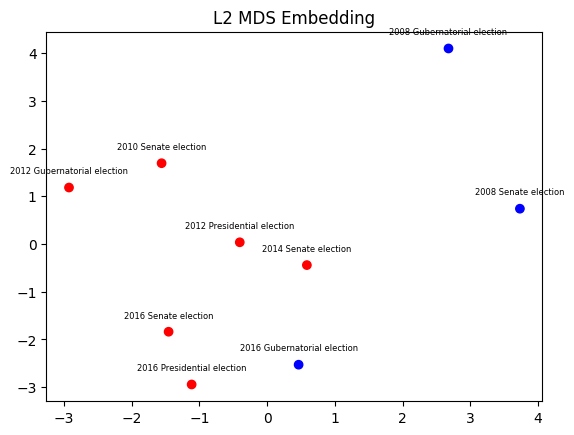

In [334]:
Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(L2_Embedding_Distances(gdf,Elections))

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Names
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)

plt.title('L2 MDS Embedding')
plt.show()

Wasserstein

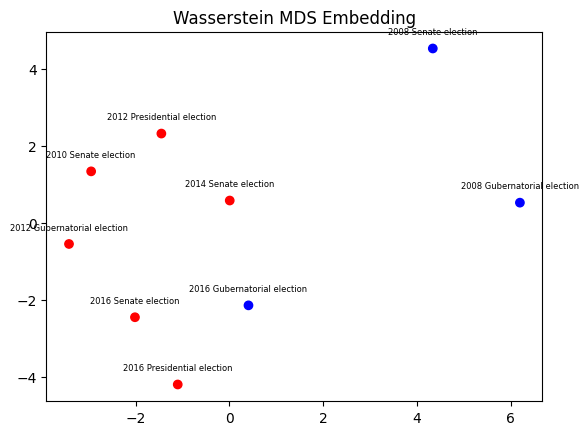

In [335]:
Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Adj_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Names
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)
plt.title('Wasserstein MDS Embedding')
plt.show()

Vinyard

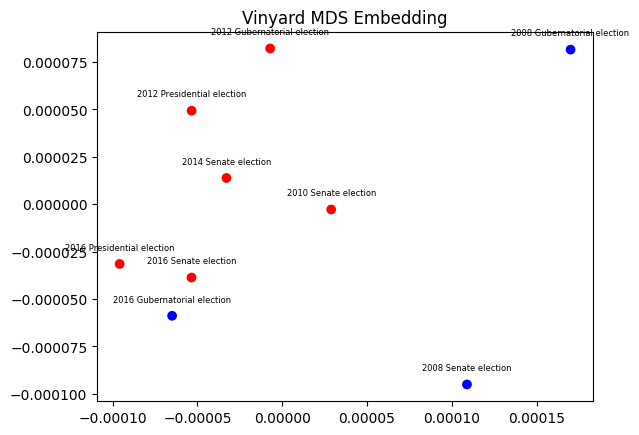

In [354]:
# Doing MDS and PLotting
Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Vinyard_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Names
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)

plt.title('Vinyard MDS Embedding')
plt.show()

Election Maps

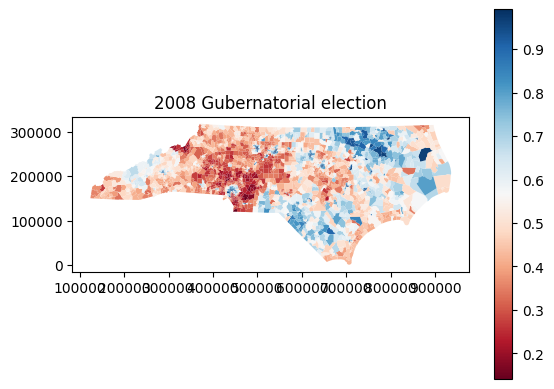

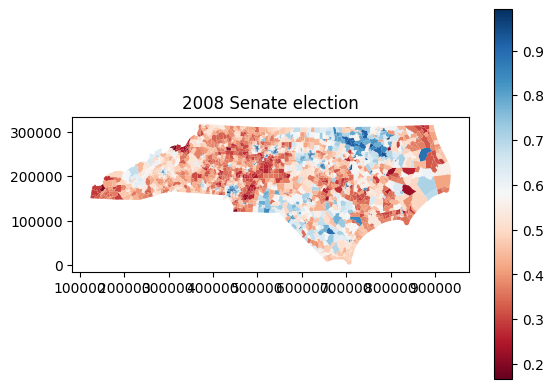

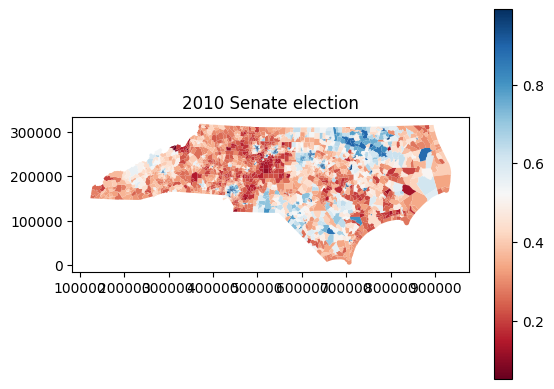

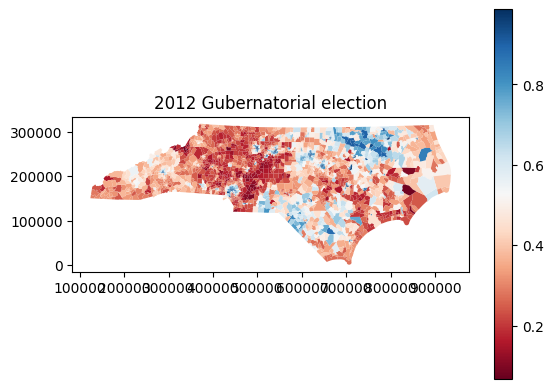

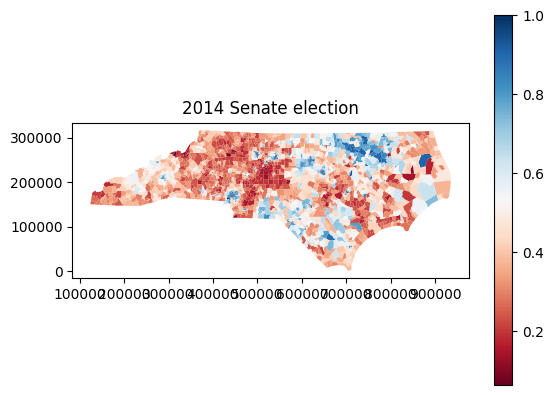

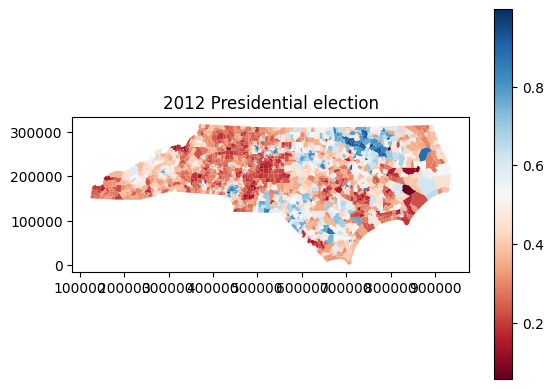

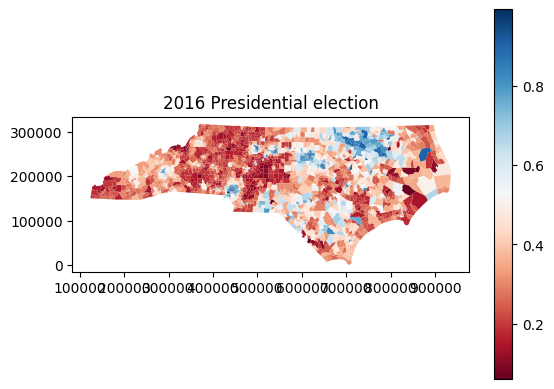

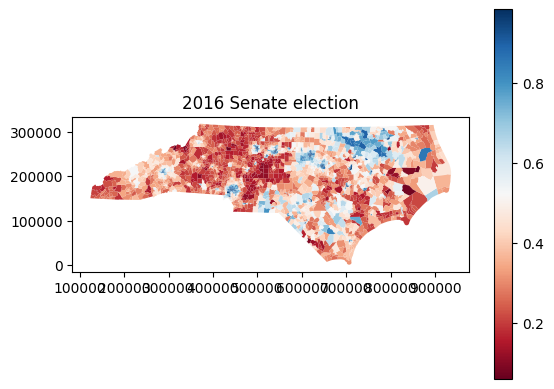

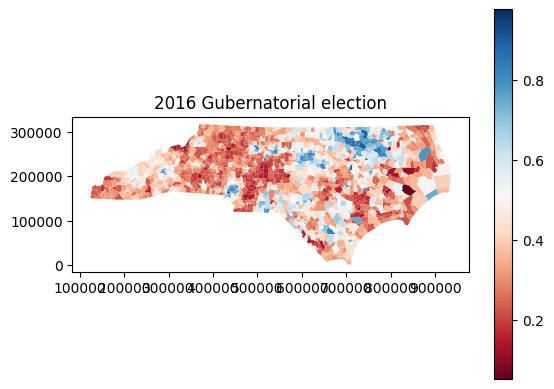

In [348]:
for x, Election in enumerate(Elections):

    gdf.plot(column=gdf[Election[0]]/(gdf[Election[0]]+gdf[Election[1]]), cmap='RdBu', legend = True)

    plt.title('{}'.format(Election_Names[x]))
    plt.savefig('/Users/dgottschalk/Desktop/NC_Elections/{}.png'.format(Election_Names[x]))


#### Guilford County

In [ ]:
guilford_county = gdf[gdf.County == '37081']
guilford_adjacency_vinyard_array = Get_Vinyard_Array(guilford_county, Elections, 11, 0)

In [ ]:
#Plot_Vinyard(guilford_adjacency_vinyard_array[2][6][0],guilford_adjacency_vinyard_array[2][6][1],guilford_adjacency_vinyard_array[2][6][2])

#for pd in (guilford_adjacency_vinyard_array[2][6][2]):
#    gudhi.plot_persistence_diagram(pd)

t = 11
ts = np.linspace(0, 1, t)
Election1= Elections[2]
Election2 = Elections[6]
D1 = gdf[Election1[0]]
R1 = gdf[Election1[1]]
D2 = gdf[Election2[0]]
R2 = gdf[Election2[1]]

Delta_D = D1 - D2
Delta_R = R1 - R2 
Hs_D = np.array([[D1 + Delta_D * t] for t in ts])
Hs_R = np.array([[R1 + Delta_R * t] for t in ts])

#print(Delta_D, Delta_R)




In [ ]:
Vinyard_Distances = np.zeros_like(guilford_adjacency_vinyard_array)
for i in range(Vinyard_Distances.shape[0]):
    for j in range(i,Vinyard_Distances.shape[1]): 
        Vinyard_Distances[i][j] = vdist(guilford_adjacency_vinyard_array[i][j][0], fD, fL)
Vinyard_Distances += Vinyard_Distances.transpose()

Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Vinyard_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Names
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)

plt.title('H0_Guilford_Vinyard_MDS')
plt.show()
print(Embedding)


############################################################################################################################################
# Adjacency #
############################################################################################################################################


# Calculating Dimension zero persistence diagrams

PDDS_0 = [Adjacency_Persistence(guilford_county, Election, 0) for Election in Elections]

# Wasserstein Distances
Adj_Distances = np.zeros( (len(PDDS_0), len(PDDS_0)) )
for i in range(Adj_Distances.shape[0]):
    for j in range(i, Adj_Distances.shape[1]):
        Adj_Distances[i][j] = gudhi.hera.wasserstein_distance(PDDS_0[i], PDDS_0[j])
Adj_Distances += Adj_Distances.transpose()

# Doing MDS and PLotting
Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Adj_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Names
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)
plt.title('H0_Guilford_Wasserstein_MDS')

plt.show()
print(Embedding)

############################################################################################################################################
# L2 #
############################################################################################################################################

Democrat_Vectors = np.array([guilford_county[Election[0]]/ (guilford_county[Election[0]]+guilford_county[Election[1]]) for Election in Elections])
L2_Distances = np.zeros( (Democrat_Vectors.shape[0], Democrat_Vectors.shape[0]) )
for i in range(L2_Distances.shape[0]):
    for j in range(i, L2_Distances.shape[1]):
        L2_Distances[i][j] = np.linalg.norm( Democrat_Vectors[i] - Democrat_Vectors[j])
L2_Distances += L2_Distances.transpose()

Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(L2_Distances)


# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Election Names 
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)
plt.title('L2_MDS')

plt.show()
print(Embedding)


In [ ]:
for pd in (guilford_adjacency_vinyard_array[2][7][2]):
    gudhi.plot_persistence_diagram(pd)

Plot_Vinyard(guilford_adjacency_vinyard_array[2][7][0], guilford_adjacency_vinyard_array[2][7][1], guilford_adjacency_vinyard_array[2][7][2])

#### Raleigh

In [ ]:
Wake_County = gdf[gdf.County == '37183']
Wake_County_Array = Get_Vinyard_Array(guilford_county, Elections, 11, 1)

In [ ]:
Vinyard_Distances = np.zeros_like(Wake_County_Array)
for i in range(Vinyard_Distances.shape[0]):
    for j in range(i,Vinyard_Distances.shape[1]): 
        Vinyard_Distances[i][j] = vdist(Wake_County_Array[i][j][0], fD, fL)
Vinyard_Distances += Vinyard_Distances.transpose()

Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Vinyard_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Names
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)

plt.show()
print(Embedding)

############################################################################################################################################
# Adjacency #
############################################################################################################################################


# Calculating Dimension zero persistence diagrams
PDDS_0 = [Adjacency_Persistence(Wake_County, Election, 1) for Election in Elections]

# Wasserstein Distances
Adj_Distances = np.zeros( (len(PDDS_0), len(PDDS_0)) )
for i in range(Adj_Distances.shape[0]):
    for j in range(i, Adj_Distances.shape[1]):
        Adj_Distances[i][j] = gudhi.hera.wasserstein_distance(PDDS_0[i], PDDS_0[j])
Adj_Distances += Adj_Distances.transpose()

# Doing MDS and PLotting
Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Adj_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Names
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)

plt.show()
print(Embedding)

############################################################################################################################################
# L2 #
############################################################################################################################################

Democrat_Vectors = np.array([Wake_County[Election[0]]/ (Wake_County[Election[0]]+Wake_County[Election[1]]) for Election in Elections])
L2_Distances = np.zeros( (Democrat_Vectors.shape[0], Democrat_Vectors.shape[0]) )
for i in range(L2_Distances.shape[0]):
    for j in range(i, L2_Distances.shape[1]):
        L2_Distances[i][j] = np.linalg.norm( Democrat_Vectors[i] - Democrat_Vectors[j])
L2_Distances += L2_Distances.transpose()

Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(L2_Distances)


# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Plotting Election Names 
for i, name in enumerate(Election_Names):
    plt.annotate(name, (Embedding[i][0], Embedding[i][1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 6)


plt.show()
print(Embedding)


In [ ]:
for x, Election in enumerate(Elections):
    Wake_County.plot(column=Wake_County[Election[0]]/(Wake_County[Election[0]]+Wake_County[Election[1]]), cmap='RdBu', legend = True)
    plt.title('{}'.format(Election_Names[x]))
    plt.show()

In [ ]:
for pd in (Wake_County_Array[2][6][2]):
    gudhi.plot_persistence_diagram(pd)

### Drafts

In [ ]:
def Get_Vinyard_Array(gdf, Elections, t = 11, d= 0):
    # INPUT:
    # gdf: A geo dataframe. This is specifically written for one found at: https://github.com/mggg-states/NC-shapefiles
    # Elections: a series of elections (in this case they are columns of the gdf) 
        # Elections should be a list of tuples with the first ell being democrat votes and the second being republican votes

    # Output:
    # Vinyard Array:
    #   a  n by n np array of Vinyard objects
    #   Vinyard Array[i,j] = the vinyard tuple generated between Elections[i] and Elections[j]
    #   Vinyard Array[i,j][0] = Points in R^3 used to plot Vinyard and Calculate distance
    #   Vinyard Array[i,j][1] = The max death value of Vinyard Array[i,j][0]
    #   Vinyard Array[i,j][2] = A list of Persistence Diagrams for the homotopy between election i and election j.

    ts = np.linspace(0, 1, t)

    Vinyard_Array = np.empty((len(Elections), len(Elections)), dtype = 'object')

    for i, Election1 in enumerate(Elections):
        for j, Election2 in enumerate(Elections):
            if j >=i:
                D1 = gdf[Election1[0]]
                R1 = gdf[Election1[1]]
                D2 = gdf[Election2[0]]
                R2 = gdf[Election2[1]]

                Delta_D = D1 - D2
                Delta_R = R1 - R2 

                # Democratic Voting values:
                    # 11 by 2692 matrix of row vectors for a straight line homotopy from election1 to election2 
                Hs_D = np.array([[D1 + Delta_D * t] for t in ts])
                
                # Republican Voting values:
                    # 11 by 2692 matrix of row vectors for a straight line homotopy from election1 to election2 
                Hs_R = np.array([[R1 + Delta_R * t] for t in ts])
                Gdf_List = []
                

                for x in range(t):
                    # creating temporary GDF so we don't edit the original
                    Gdf_Temp = gdf.copy()
                    # Setting the Democrat Values of Election 1 to be (D1 + Delta_D * t)
                    Gdf_Temp[Election1[0]] = Hs_D[x].transpose()
                    # Setting the Republican Values of Election 1 to be (R1 + Delta_R * t)
                    Gdf_Temp[Election1[1]] = Hs_R[x].transpose()
                    # Adding our eddited gdf to our gdf list
                    Gdf_List.append(Gdf_Temp)
                
                # now we have a gdf list with t many gdfs. We can now run adjacency persistence on each to construct a vinyard from election1 to election 2
                PDDS = [Adjacency_Persistence(Gdf_List[x], Election1, dimension = d) for x in range(t)]

                # Getting Rid of Infinity Values (This messes with Distance Calculations)
                for PDD in PDDS:
                    mx = np.max(PDD[np.isfinite(PDD)])
                    PDD[np.isinf(PDD)] = mx
                    # infinity check before we calculate Vinyard
                for PDD in PDDS:
                    if np.any(np.isinf(PDD)):
                        print('{} Failed Infinity Check :('.format(Election1))
                        print(PDD)
                        break
                
                Vinyard_Array[i,j] = Get_Vinyard(PDDS, t)
                print(j)
        print(i)
    return Vinyard_Array